# Packages


In [156]:
import nilmtk
import pandas as pd
import numpy as np
import matplotlib.font_manager
import matplotlib.pyplot as plt
from time import time
import nilmtk
nilmtk.Appliance.allow_synonyms=False
import scipy.stats 
from datetime import datetime, timedelta
from sklearn.model_selection import TimeSeriesSplit
#import seaborn as sns
import math
from math import pi
import pickle

#load REFIT dataset
dataset = nilmtk.DataSet('REFIT.h5')


# Define functions to compute SNR and ANR

In [157]:
def SNR (mains, noise):
    list_aux1 = [abs(mains[i]) for i in range(0, len(noise))]
    list_aux2 = [abs(noise[i]) for i in range(0, len(noise))]
    return sum(list_aux1)/sum(list_aux2)

#get SNR in decibel scale
def SNR_dB (mains, noise):
    return 10*math.log10(SNR(mains, noise))

def ANR(app, noise):
    list_aux = [abs(app[i])/abs(noise[i]) for i in range(0, len(noise)) if app[i] >=0 if abs(noise[i]) > 0.005]
    if len(list_aux) == 0:
        print("ANR not defined")
    else:
        return sum(list_aux)/len(list_aux)
    

# Get noise/SNR/ANR for each house (whole experiment period)

In [158]:
noise_dict = {}


In [159]:
load, BUILDING, SAMPLE_RATE, d1, d2 = "computer", 1, 60, '2014-06-20', '2015-06-20'

#get total noise in building aggregate between dates d1 and d2 with a sample rate of 1/60 Hz

def get_noise(mains, sample_rate, building, d1, d2):
    noise_seq2 = mains[d1:d2].values.flatten().tolist()
    for j in range(1, len(dataset.buildings[building].elec.appliances)):
        APPJ1 = dataset.buildings[building].elec[j+1]
        if APPJ1.appliances[0].type['type'] != 'unknown' or APPJ1.appliances[0].type['type'] != 'appliance':
            dataset_aux = next(APPJ1.load(sample_period = sample_rate))['power'][d1:d2].values.flatten().tolist()
            if len(noise_seq2) != len(dataset_aux):
                print("length of mains and appliance sequences differ")
            else:
                noise_seq2 = [noise_seq2[i] - dataset_aux[i] for i in range(0, len(noise_seq2))]
    return noise_seq2

#The REFIT houses ID goes from 1 to 21, except 14. 
#However, the houses numbered > = 15 must be called by (ID-1) because the houses are ordered without gap in the dataset.

Houses =  ['1', '5', '6', '14', '15', '17', '19'] 

for i in Houses:
    dataset_mains = next(dataset.buildings[int(i)].elec[1].load(sample_period = SAMPLE_RATE))['power'][d1:d2]
    noise_dict[i] = get_noise(dataset_mains, SAMPLE_RATE, int(i), d1, d2)
    
# elec[1] refers to the mains or aggregate data


## Compute noise

In [ ]:
noise_house = {}

for i in Houses:
    A = get_noise(dataset_mains, SAMPLE_RATE, BUILDING, '2014-06-20', '2015-06-20')
    noise_house[i] = A
    

## Compute SNR 

In [160]:
snr_houses = []

for i in Houses:
    A = noise_dict[i]
    A = [x for x in A if str(x) != 'nan']
    B =  next(dataset.buildings[int(i)].elec[1].load(sample_period = SAMPLE_RATE))['power'][d1:d2].values.flatten().tolist()
    B = [x for x in B if str(x) != 'nan']
    snr_houses.append(SNR_dB(B, A))
    

## Compute ANR 

In [161]:
anr_houses = []

for i in Houses:
    A = noise_dict[i]
    A = [x for x in A if str(x) != 'nan']
    B =  next(dataset.buildings[int(i)].elec[load].load(sample_period = SAMPLE_RATE))['power'][d1:d2].values.flatten().tolist()
    B = [x for x in B if str(x) != 'nan']
    anr_houses.append(ANR(B, A))
    

## Plot SNR / ANR for each house

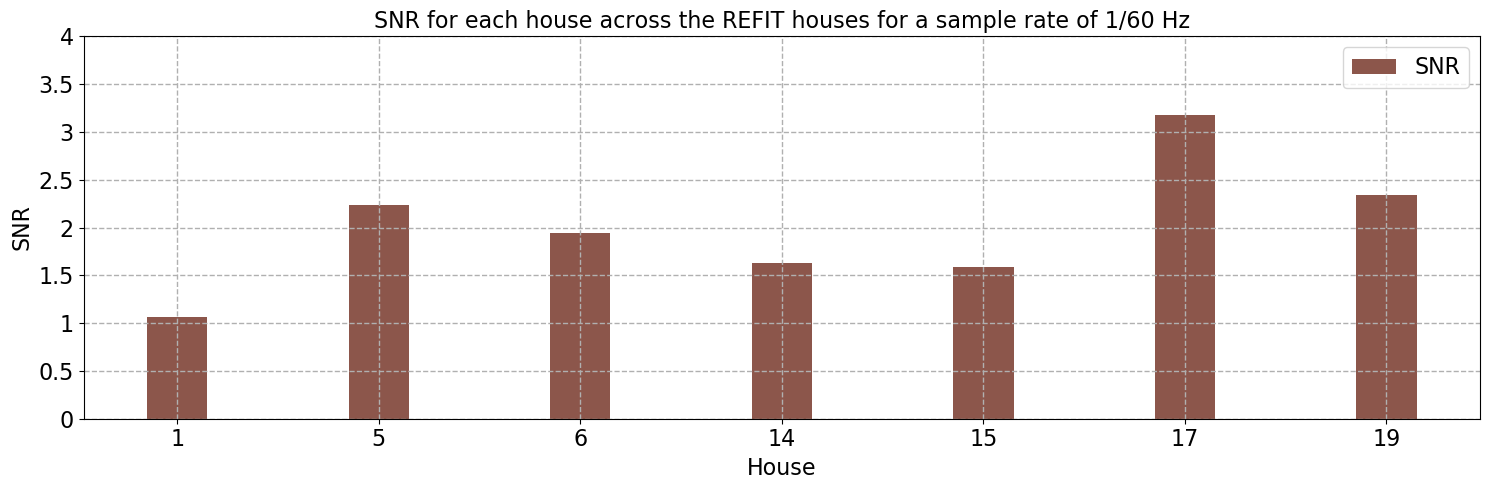

In [165]:
labels, x, width = Houses, np.arange(7), 0.3

plt.rcParams["figure.figsize"] = (15,5)

fig, ax = plt.subplots()

rects1 = ax.bar(x, snr_houses, width, label='SNR', color = "tab:brown")

ax.set_ylabel('SNR', fontsize = 16)
ax.set_xlabel('House', fontsize = 16)
ax.set_title("SNR for each house across the REFIT houses for a sample rate of 1/60 Hz", fontsize = 16)
ax.set_xticks(x)
ax.set_yticks(np.arange(0, 4.5, 0.5))
ax.set_yticklabels([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5] , fontsize = 16)
ax.set_xticklabels(labels, fontsize = 16)
ax.legend(fontsize = 16)
ax.grid(linestyle = '--', linewidth = 1)

fig.tight_layout()
plt.show()


# Get noise/SNR/ANR for bi-weekly/monthly periods

In [166]:
load, BUILDING, SAMPLE_RATE, d1, d2 = "computer", 1, 60, '2014-06-20', '2015-06-20'

dataset_mains = next(dataset.buildings[BUILDING].elec[1].load(sample_period = SAMPLE_RATE))['power']

dataset_app = next(dataset.buildings[BUILDING].elec[load].load(sample_period = SAMPLE_RATE))['power'][d1:d2]

#get total noise in building aggregate between dates d1 and d2

def get_noise2(mains, sample_rate, building, d1, d2):
    noise_seq2 = mains[d1:d2].values.flatten().tolist()
    for j in range(1, len(dataset.buildings[building].elec.appliances)):
        APPJ1 = dataset.buildings[building].elec[j+1]
        if APPJ1.appliances[0].type['type'] != 'unknown' or APPJ1.appliances[0].type['type'] != 'appliance':
            dataset_aux = next(APPJ1.load(sample_period = sample_rate))['power'][d1:d2].values.flatten().tolist()
            if len(noise_seq2) != len(dataset_aux):
                print("length of mains and appliance sequences differ")
            else:
                noise_seq2 = [noise_seq2[i] - dataset_aux[i] for i in range(0, len(noise_seq2))]
    return noise_seq2


#set the dates

set_dates_biweekly = ['2014-06-20', '2014-07-04', '2014-07-18', '2014-08-01', '2014-08-15', '2014-08-29', '2014-09-12', '2014-09-26',
            '2014-10-10', '2014-10-24', '2014-11-07', '2014-11-21', '2014-12-05', '2014-12-19', '2015-01-02', '2015-01-16',
            '2015-01-30', '2015-02-13', '2015-02-27', '2015-03-13', '2015-03-27', '2015-04-10', '2015-04-24', '2015-05-08', 
            '2015-05-22', '2015-06-05', '2015-06-20']

set_dates_month = ['2014-06-20', '2014-07-20', '2014-08-20', '2014-09-20', '2014-10-20', '2014-11-20', '2014-12-20', '2015-01-20',
            '2015-02-20', '2015-03-20', '2015-04-20', '2015-05-20', '2015-06-20']

#alter dates set for hourly, bi-weekly and monthly


## Compute SNR 

In [168]:
snr_biweek = []

for i in range(1, len(set_dates_biweekly)):
    A = get_noise2(dataset_mains, SAMPLE_RATE, BUILDING, set_dates_biweekly[i-1], set_dates_biweekly[i])
    A = [x for x in A if str(x) != 'nan']
    B = dataset_mains[set_dates_biweekly[i-1]: set_dates_biweekly[i]].values.flatten()
    B = [x for x in B if str(x) != 'nan']
    snr_biweek.append(SNR_dB(B, A))
    

## Compute ANR

In [167]:
anr_biweek = []

for i in range(1, len(set_dates_biweekly)):
    A = get_noise2(dataset_mains, SAMPLE_RATE, BUILDING, set_dates_biweekly[i-1], set_dates_biweekly[i])
    A = [x for x in A if str(x) != 'nan']
    C = dataset_app[set_dates_biweekly[i-1]: set_dates_biweekly[i]].values.flatten()
    C = [x for x in C if str(x) != 'nan']
    anr_biweek.append(ANR(C, A))
    

## Compute noise

In [182]:
noise_biweek = []

for i in range(1, len(set_dates_biweekly)):
    A = get_noise2(dataset_mains, SAMPLE_RATE, BUILDING, set_dates_biweekly[i-1], set_dates_biweekly[i])
    A = [x for x in A if str(x) != 'nan' if x>70 and x<2000]
    noise_biweek.append(A)
    

## Compute appliance consumption

In [175]:
app_data_biweekly = []

for i in range(1, len(set_dates_biweekly)):
    dat = dataset_app[set_dates_biweekly[i-1]:set_dates_biweekly[i]].values.flatten().tolist()
    dat = [x for x in dat if str(x) != 'nan' if x>=0 if x<70]
    app_data_biweekly.append(dat)
    

# Get noise/SNR/ANR for each hour of the day

In [170]:
BUILDING, SAMPLE_RATE, d1, d2 = 1, 60, '2014-06-20', '2015-06-20'

#get total noise in building aggregate

def get_noise_hours(mains, sample_rate, building, hour1, hour2):
    noise_seq2 = mains.between_time(hour1, hour2).values.flatten().tolist()
    appliance_list = ["dish washer", "computer", "washing machine", "television"]
    for j in range(0, len(appliance_list)):
        APPJ1 = dataset.buildings[building].elec[appliance_list[j]]
        dataset_aux = next(APPJ1.load(sample_period = sample_rate))['power'][d1:d2].between_time(hour1, hour2).values.flatten().tolist()
        if len(noise_seq2) != len(dataset_aux):
            print("length of mains and selected appliance sequences differ")
        else:
            noise_seq2 = [noise_seq2[i] - dataset_aux[i] for i in range(0, len(noise_seq2))]
    return noise_seq2

dataset_mains = next(dataset.buildings[BUILDING].elec[1].load(sample_period = SAMPLE_RATE))['power'][d1:d2]
dataset_app = next(dataset.buildings[BUILDING].elec["computer"].load(sample_period = SAMPLE_RATE))['power'][d1:d2]

set_hours = ['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00', '08:00', '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00',
            '23:00', '00:00']


## Compute SNR

In [171]:
snr_hour = []

for i in range(1, len(set_hours)):
    A = get_noise_hours(dataset_mains, SAMPLE_RATE, BUILDING, set_hours[i-1], set_hours[i])
    A = [x for x in A if str(x) != 'nan']
    B = dataset_mains.between_time(set_hours[i-1], set_hours[i]).values.flatten()
    B = [x for x in B if str(x) != 'nan']
    snr_hour.append(SNR_dB(B, A))
    

## Compute ANR

In [172]:
anr_hour = []

for i in range(1, len(set_hours)):
    A = get_noise_hours(dataset_mains, SAMPLE_RATE, BUILDING, set_hours[i-1], set_hours[i])
    A = [x for x in A if str(x) != 'nan']
    C = dataset_app.between_time(set_hours[i-1], set_hours[i]).values.flatten()
    C = [x for x in C if str(x) != 'nan']
    anr_hour.append(ANR(C, A))
    

## Compute noise

In [173]:
noise_hour = []

for i in range(1, len(set_hours)):
    A = get_noise_hours(dataset_mains, SAMPLE_RATE, BUILDING, set_hours[i-1], set_hours[i])
    A = [x for x in A if str(x) != 'nan' if x>70 and x<2000]
    noise_hour.append(A)
    

## Compute appliance consumption

In [174]:
app_data_hour = []

for i in range(1, len(set_hours)):
    #dataset_app.between_time(set_hours[i-1], set_hours[i])
    dat = dataset_app.between_time(set_hours[i-1],set_hours[i]).values.flatten().tolist()
    dat = [x for x in dat if str(x) != 'nan' if x>0 if x<70]
    app_data_hour.append(dat)
    

#############################################################################################################

# Plot noise/appliance power distribution hourly/bi-weekly/monthly

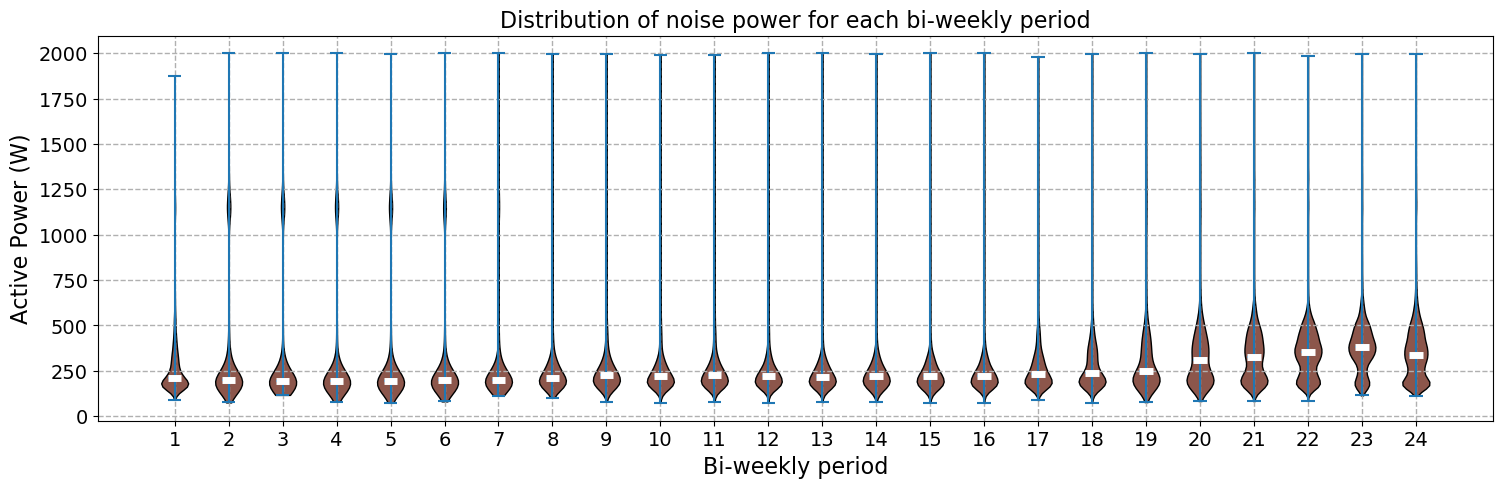

In [180]:
labels = ["1",  "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19",
          "20", "21", "22", "23", "24"]  # ----> hourly

#labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16',
#         '17', '18', '19', '20', '21', '22', '23', '24', '25', '26'] # -----> bi-weekly

#labels = ["1",  "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"] #---> monthly

plt.rcParams["figure.figsize"] = (18, 5)
labels, data = labels, noise_hour

plt.violinplot(data, showmedians = True)

parts = plt.violinplot(
        data, showmeans=False, showmedians=True,
        showextrema=False)

parts['cmedians'].set_color('white')    
parts['cmedians'].set_linewidth(5)

for p in parts['bodies']:
    p.set_facecolor('tab:brown')
    p.set_edgecolor('black')
    p.set_alpha(1)

plt.xticks(range(1, len(labels) + 1), labels, fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(linestyle = '--', linewidth = 1)
plt.title("Distribution of noise power for each bi-weekly period", fontsize = 16)
plt.xlabel("Bi-weekly period", fontsize = 16)
plt.ylabel("Active Power (W)", fontsize = 16)
plt.show()


## Plot ANR/SNR for hourly/bi-weekly/monthly periods

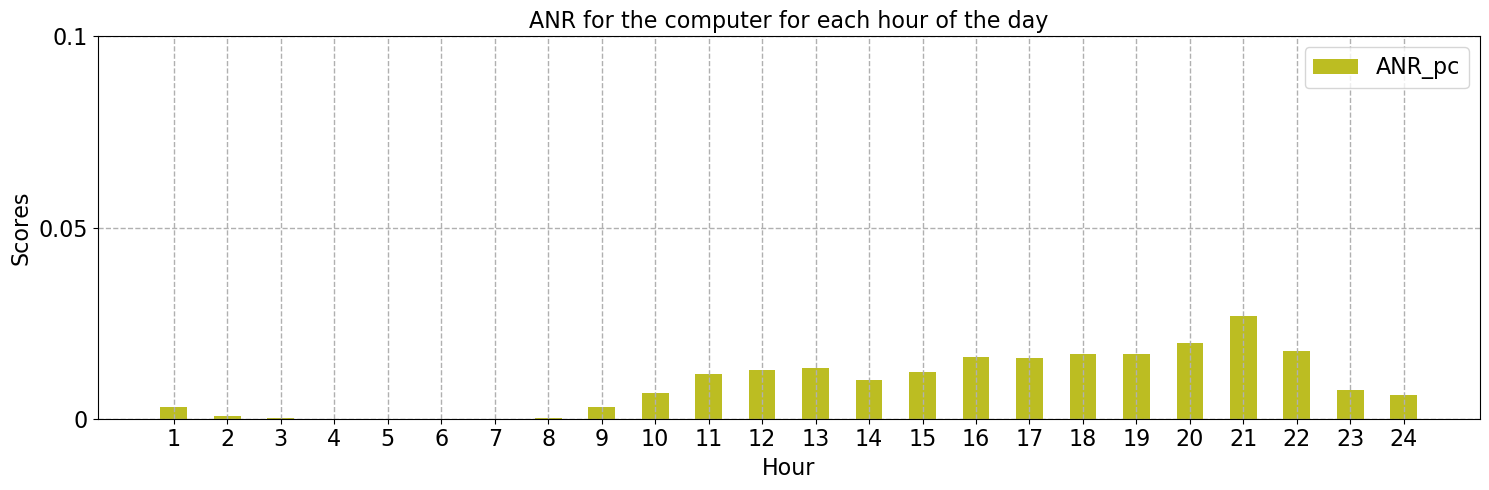

In [181]:
x, width = np.arange(len(labels)), 0.5 

plt.rcParams["figure.figsize"] = (15,5)

fig, ax = plt.subplots()

rects1 = ax.bar(x, anr_hour, width, label='ANR_pc', color = "tab:olive")

ax.set_ylabel('Scores', fontsize = 16)
ax.set_xlabel('Hour', fontsize = 16)
ax.set_title("ANR for the "+str(load)+" for each hour of the day", fontsize = 16)
ax.set_xticks(x)
ax.set_yticks(np.arange(0, 0.15, 0.05))
ax.set_yticklabels( [0, 0.05, 0.1, 0.15], fontsize = 16)
ax.set_xticklabels(labels, fontsize = 16)
ax.legend(fontsize = 16)
ax.grid(linestyle = '--', linewidth = 1)

fig.tight_layout()
plt.show()
